In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline
# Make a neural network architecture
import keras
from keras.layers import Dense, Input, Concatenate
from keras.models import Model
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
def normalize(u,mean,std):
    unorm = (u - mean) / std  # Mean of 0.0 and variance of 1.0
    return unorm

In [4]:
def load_data(filename,data_size):
    #Loading data from Tecplot file (check number of skiprows) - no tecplot header
    fine_data = np.loadtxt(filename)

    # Store in numpy array
    vort_fc= np.arange((data_size + 1)* (data_size + 1), dtype='double').reshape(data_size + 1, data_size + 1)
    vort_cs = np.arange((data_size + 1) * (data_size + 1), dtype='double').reshape(data_size + 1, data_size + 1)

    iter = 0
    for j in range(0, data_size + 1):
        for i in range(0, data_size + 1):
            vort_fc[i, j] = fine_data[iter, 0]
            vort_cs[i, j] = fine_data[iter, 1]
            iter = iter + 1

    vort_fc_per = np.arange((data_size) * (data_size), dtype='double').reshape(data_size, data_size)
    vort_cs_per = np.arange((data_size) * (data_size), dtype='double').reshape(data_size, data_size)

    for j in range(0, data_size):
        for i in range(0, data_size):
            vort_fc_per[i, j] = vort_fc[i, j]
            vort_cs_per[i, j] = vort_cs[i, j]
            
    #Normalizing inputs to mean of 0.0 and variance of 1.0
    vort_fc_mean = np.mean(vort_fc_per)
    vort_fc_std = np.std(vort_fc_per)

    vort_fc_per = normalize(vort_fc_per, vort_fc_mean, vort_fc_std)
    vort_cs_per = normalize(vort_cs_per, vort_fc_mean, vort_fc_std)


    return [vort_fc_per, vort_cs_per]

In [5]:
def make_training_data(data_dict, data_size, max_iter):

    stencil_matrix = np.zeros((max_iter,9),dtype='double')
    source_matrix = np.zeros((max_iter, 1), dtype='double')

    global seed_val
    np.random.seed(seed_val)

    for iter in range(0,max_iter):
        i = np.random.randint(1, data_size-1)
        j = np.random.randint(1, data_size-1)

        sub_iter = 0
        #Inputs are \bar{omega} 
        stencil_matrix[iter, sub_iter + 0] = data_dict[0][i, j]
        stencil_matrix[iter, sub_iter + 1] = data_dict[0][i, j + 1]
        stencil_matrix[iter, sub_iter + 2] = data_dict[0][i, j - 1]
        stencil_matrix[iter, sub_iter + 3] = data_dict[0][i + 1, j]
        stencil_matrix[iter, sub_iter + 4] = data_dict[0][i + 1, j + 1]
        stencil_matrix[iter, sub_iter + 5] = data_dict[0][i + 1, j - 1]
        stencil_matrix[iter, sub_iter + 6] = data_dict[0][i - 1, j]
        stencil_matrix[iter, sub_iter + 7] = data_dict[0][i - 1, j + 1]
        stencil_matrix[iter, sub_iter + 8] = data_dict[0][i - 1, j - 1]

        #Outputs are \omega^c
        source_matrix[iter, 0] = data_dict[1][i, j]

        #You can flip the data_dict[index] for training other map
    return [stencil_matrix, source_matrix]

In [6]:
data_size = 256
#Test data generation
seed_val = 1
#Large unnormalized databank generated
max_iter = 30000#A maximum of 256*256 is possible - choose a number lesser than it for random sampling

t_init = 0
t_end = 4

for time in range(t_init,t_end+1):
    filename = r'./DDDKT/Source.' + str(500+time)
    data_dict = load_data(filename, data_size)

    if time == t_init:
        training_dict = make_training_data(data_dict, data_size, max_iter)

    else:
        training_dict_temp = make_training_data(data_dict, data_size, max_iter)

        training_dict[0] = np.concatenate((training_dict[0],training_dict_temp[0]),axis=0)
        training_dict[1] = np.concatenate((training_dict[1],training_dict_temp[1]),axis=0)


In [7]:
import keras.backend as K
def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [8]:
X=training_dict[0]
y=training_dict[1]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=0.2,random_state = 0)

In [10]:
X_train.shape

(120000, 9)

In [22]:

input_layer = Input(shape=(9,))

layer_1_output = Dense(9,activation='relu')(input_layer)
layer_2_output = Dense(50,activation='relu')(layer_1_output)
layer_3_output = Dense(50,activation='relu')(layer_2_output)
layer_4_output = Dense(50,activation='relu')(layer_3_output)
skipped1 = Concatenate()([layer_2_output,layer_4_output])
layer_5_output = Dense(50,activation='relu')(skipped1)
layer_6_output = Dense(50,activation='relu')(layer_5_output)
layer_7_output = Dense(50,activation='relu')(layer_6_output)
skipped2 = Concatenate()([layer_5_output,layer_7_output])
X = Dense(1)(skipped2)

model = Model(inputs = [input_layer],outputs = [X])
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train,y_train,epochs=50,batch_size=1024,verbose=1)

Epoch 1/50
120000/120000 [==============================] - 1s 11us/step - loss: 0.2089
Epoch 2/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0862
Epoch 3/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0740
Epoch 4/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0672
Epoch 5/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0632
Epoch 6/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0607
Epoch 7/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0587
Epoch 8/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0575
Epoch 9/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0566
Epoch 10/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0561
Epoch 11/50
120000/120000 [==============================] - 1s 6us/step - loss: 0.0557
Epoch 12/50
120000/120000 [=============

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 9)            90          input_5[0][0]                    
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 50)           500         dense_21[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 50)           2550        dense_22[0][0]                   
__________________________________________________________________________________________________
dense_24 (

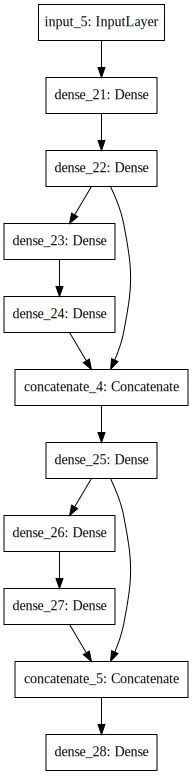

In [24]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))